In [1]:
import numpy as np
import csv
import random

没考虑数据不平衡的问题
数据集太多，内存放不下

In [28]:
#读取文件
train_filepath = "./sentiment-analysis-on-movie-reviews/train.tsv"
test_filepath = "./sentiment-analysis-on-movie-reviews/test.tsv"

with open(train_filepath)as f:
    fread = csv.reader(f,delimiter='\t')
    data = list(fread)

#去掉表头
data = data[1:]
len(data)

156060

In [24]:
#n-元语法--特征提取--内存溢出版
model = N_Gram(data,2)
model.get_words()
print(model.diction_size)
model.get_matrix()

MemoryError: Unable to allocate 81.9 GiB for an array with shape (109242, 100663) and data type float64

In [40]:
#n-元语法--特征提取--正常版
model = N_Gram(data,2,10000)
model.get_words()
print(model.diction_size)
model.get_matrix()

8915


0.19657142857142856 0.196
0.203 0.20666666666666667
0.19485714285714287 0.19233333333333333
0.19842857142857143 0.19266666666666668
0.2077142857142857 0.19833333333333333
0.252 0.24433333333333335
0.24457142857142858 0.256
0.2631428571428571 0.24833333333333332


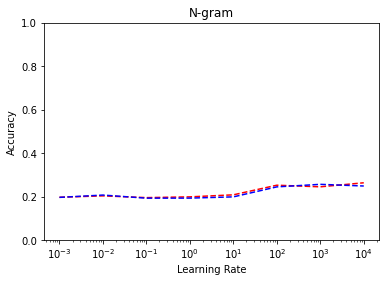

In [43]:
model_plot(model,10000,10)